In [1]:
suppressMessages(library("rwwa"))

# Revert synthesis functions to match climate explorer

In [4]:
getsynmean_cx <- function(data, sig_mod = 0) {

  # calculate weight for each model based on inverse variance
  w = 1/(((data$upper - data$lower))^2 + (2*sig_mod)^2)     # w = 1/(((data$upper - data$lower)/(2*1.96))^2 + sig_mod^2)
  w1 = sum(w)
    
    print(w)

  # weighted sum of squares & bounds
  s1 <- sum(w*data$est) / w1
  ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
  ss2 <- sqrt(ss2) / w1

  # if non-zero model representation error, extend 95% intervals accordingly
  if (sig_mod > 0) {
      ss2 <- sqrt(ss2^2 + (2*sig_mod)^2)     # ss2 <- sqrt(ss2^2 + (1.96*sig_mod)^2)
  }

  return(s1 + (ss2 * c(0,-1,1)))
}

In [5]:
getsynchi2_cx <- function(data, sig_mod = 0) {

  # function to be minimized by finding sig_mod such that chi^2/mdof ~= 1

  # get best estimate of weighted mean
  s1 <- getsynmean_cx(data, sig_mod)["est"]

  # compute chi2 by converting model intervals to standard deviations & adding sig_mod adjustment
  chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
    if(x["est"] > s1) {
      (x["est"] - s1)^2 / (((x["est"] - x["lower"]))^2 + sig_mod^2)     # (x["est"] - s1)^2 / (((x["est"] - x["lower"])/1.96)^2 + sig_mod^2)
    } else {
      (x["est"] - s1)^2 / (((x["est"] - x["upper"]))^2 + sig_mod^2)     # (x["est"] - s1)^2 / (((x["est"] - x["upper"])/1.96)^2 + sig_mod^2)
    }
  }))
  return(chi2*4)
}

In [6]:
getsynchi2_cb <- function(data, sig_mod = 0) {

  # function to be minimized by finding sig_mod such that chi^2/mdof ~= 1

  # get best estimate of weighted mean
  s1 <- getsynmean_cx(data, sig_mod)["est"]

  # compute chi2 by converting model intervals to standard deviations & adding sig_mod adjustment
  chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
    if(x["est"] > s1) {
      (x["est"] - s1)^2 / (((x["est"] - x["lower"])/2)^2 + sig_mod^2)     # (x["est"] - s1)^2 / (((x["est"] - x["lower"])/1.96)^2 + sig_mod^2)
    } else {
      (x["est"] - s1)^2 / (((x["est"] - x["upper"])/2)^2 + sig_mod^2)     # (x["est"] - s1)^2 / (((x["est"] - x["upper"])/1.96)^2 + sig_mod^2)
    }
  }))
  return(chi2)
}

In [7]:
synthesis_cx <- function(obs_in = NA, models_in, synth_type = "abs") {

  if(is.na(unlist(obs_in))[1]) {
    no_obs <- T
    # create a dummy dataframe to avoid having to rewrite everything twice
    obs_in <- data.frame("est" = 0, "lower" = 0, "upper" = 0)
    rownames(obs_in) <- "dummy"
  } else {
    no_obs <- F
  }

  # relabel the data for easier reference later
  colnames(obs_in) <- colnames(models_in) <- c("est", "lower", "upper")

  if(!("model" %in% colnames(obs_in))) obs_in$model <- rownames(obs_in)
  if(!("model" %in% colnames(models_in))) models_in$model <- rownames(models_in)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  if(!synth_type %in% c("abs", "rel", "PR")) {
    cat(paste0("Synthesis type '",synth_type,"' not implemented - must be abs, rel or PR"), "\n")
  }

  if(synth_type == "PR") {
    obs_in[,c("est", "lower", "upper")] <- log(obs_in[,c("est", "lower", "upper")])
    models_in[,c("est", "lower", "upper")] <- log(models_in[,c("est", "lower", "upper")])
  } else if(synth_type == "rel") {
    obs_in[,c("est", "lower", "upper")] <- log(1+obs_in[,c("est", "lower", "upper")]/100)
    models_in[,c("est", "lower", "upper")] <- log(1+models_in[,c("est", "lower", "upper")]/100)
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get mean of intervals to estimate natural variability component

  # compute representation error from scatter of mean ($\sigma_{rep}$ in the paper)
  nobs = nrow(obs_in)
  obs <- apply(obs_in[,c("est", "lower", "upper"),drop = F], 2, mean)
  if(nobs == 1) {
    sig_obs = 0
  } else {
    s2 = sum((obs_in$est - obs[1])^2)
    sig_obs = 2 * sqrt(s2/(nobs-1))     # sig_obs = sqrt(s2/(nobs-1))
  }

  # add representation error to individual observations
  obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + (sig_obs)**2)     # obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + (1.96*sig_obs)**2)
  obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + (sig_obs)**2)     # obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + (1.96*sig_obs)**2)

  # apply representation error to obs synthesis
  # we're working with confidence intervals here, so we extend them by adding (1.96sig_obs)^2 in quadrature
  obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + (sig_obs)**2 )     # obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + (1.96*sig_obs)**2 )
  obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + (sig_obs)**2 )     # obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + (1.96*sig_obs)**2 )

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get initial estimate of model mean & calculate chi^2
  chi2 <- getsynchi2_cx(models_in, sig_mod = 0)
  mdof <- nrow(models_in)-1

  if ( chi2/mdof > 1 ) {
    # find sig_mod such that chi^2/dof = 1
    sig_mod <- optim(0, function(x) {
        (getsynchi2_cx(models_in, sig_mod = x) - (nrow(models_in)-1))^2},
                     method = "Brent", lower = 0, upper = 5)$par
      } else {
        sig_mod <- 0
      }
    cat("sig_mod: ", sig_mod,"\n")

  # get weighted model mean
  models <- getsynmean_cx(models_in, sig_mod = sig_mod)

  # add representation error to individual models
  models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + (2*sig_mod)**2)     # models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + (2*sig_mod)**2)
  models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + (2*sig_mod)**2)     # models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + (2*sig_mod)**2)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # weighted mean of models & obs (coloured bar)
  w_obs <- unname((obs["upper"] - obs["lower"])^{-2})
  w_mod <- unname((models["upper"] - models["lower"])^{-2})

  wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
  synth <- setNames(c(wmean,
                      wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                      wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)),
                    c("est", "lower", "upper"))


  # unweighted mean of obs and models
  umean <- (obs["est"] +  models["est"]) / 2
  synth["l_wb"] <- umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2
  synth["u_wb"] <- umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # add group labels for easier plotting
  obs_in <- cbind(obs_in, "group" = "obs")
  obs <- data.frame(t(c("model" = "Observations", "group" = "obs_synth", obs)))
  models_in <- cbind(models_in, "group" = "models")
  models <- data.frame(t(c("model" = "Models", "group" = "model_synth", models)))
  synth <- data.frame(t(c("model" = "Synthesis", "group" = "synth", synth)))

  # combine all the data together in one dataframe
  res <- rbind.fill(obs_in, obs, models_in, models, synth)[,c("group", "model", "est", "lower", "upper", "l_wb", "u_wb")]
  for(cnm in c("est", "lower", "upper", "l_wb", "u_wb")) { res[,cnm] <- as.numeric(res[,cnm]) }

  # if only dummy obs, remove
  if(no_obs) {
    # drop all rows that don't relate to models
    res <- res[grepl("model", res$group),]
    sig_obs <- NA
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # reverse any transformations applied
  if(synth_type == "PR") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])
    sig_obs <- exp(sig_obs)
    sig_mod <- exp(sig_mod)
    umean <- exp(umean)
  } else if(synth_type == "rel") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- 100*(exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])-1)
    sig_obs <- 100*(exp(sig_obs)-1)
    sig_mod <- 100*(exp(sig_mod)-1)
    umean <- 100*(exp(umean)-1)
  }

  return(list(synth_type = synth_type, sig_obs = sig_obs, "chi2/dof" = chi2 / mdof, df = res, uw_mean = umean))
}

In [8]:
df = read.csv("dI_sahel-tx5x-future.txt", sep = "\t", row.names = "model")

In [9]:
synth <- synthesis_cx(models_in = df)
synth$"chi2/dof"     # CX has chi2/dof = 3.716

synth$df
# 3.71572967348589

 [1] 16.935088 22.461310 22.675737 36.730946 25.767219 25.000000 20.108991
 [8] 11.037406 11.809024  2.768542  7.344247
 [1] 0.06826473 0.06833250 0.06833447 0.06841336 0.06835918 0.06835362
 [7] 0.06830819 0.06811801 0.06814549 0.06688514 0.06790727
 [1] 0.02613993 0.02614986 0.02615015 0.02616169 0.02615377 0.02615295
 [7] 0.02614630 0.02611839 0.02612243 0.02593509 0.02608735
 [1] 0.1775613 0.1780205 0.1780339 0.1785703 0.1782017 0.1781639 0.1778556
 [8] 0.1765721 0.1767568 0.1685201 0.1751629
 [1] 0.4571068 0.4601627 0.4602518 0.4638545 0.4613754 0.4611220 0.4590625
 [8] 0.4506078 0.4518131 0.4016347 0.4415431
 [1] 1.1466432 1.1660681 1.1666408 1.1900698 1.1738868 1.1722479 1.1590294
 [8] 1.1066074 1.1139047 0.8515981 1.0534934
 [1] 2.705547 2.816243 2.819586 2.960445 2.862287 2.852562 2.775534 2.492752
 [9] 2.530089 1.488620 2.238524
 [1] 5.628313 6.129512 6.145370 6.856400 6.351903 6.304211 5.939896 4.779541
 [9] 4.918715 2.084093 3.924876
 [1] 4.549196 4.871133 4.881143 5.319288

[1] 3.71573

,group,model,est,lower,upper,l_wb,u_wb
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,models,ACCESS-CM2_r1i1p1f1,1.0270000,0.9060000,1.14900,0.5914573,1.462822
4,models,ACCESS-ESM1-5_r1i1p1f1,0.9930000,0.8910000,1.10200,0.5623489,1.425363
5,models,AWI-CM-1-1-MR_r1i1p1f1,0.8260000,0.7240000,0.93400,0.3953489,1.258112
6,models,EC-Earth3_r1i1p1f1,0.9610000,0.8780000,1.04300,0.5344494,1.387357
7,models,EC-Earth3-Veg_r1i1p1f1,1.0430000,0.9480000,1.14500,0.6139529,1.473651
8,models,EC-Earth3-Veg-LR_r1i1p1f1,1.1320000,1.0300000,1.23000,0.7013489,1.561721
9,models,INM-CM5-0_r1i1p1f1,0.8550000,0.7360000,0.95900,0.4200087,1.286129
10,models,MPI-ESM1-2-HR_r1i1p1f1,0.9050000,0.7470000,1.04800,0.4577636,1.347160
11,models,MPI-ESM1-2-LR_r1i1p1f1,0.8750000,0.7300000,1.02100,0.4321892,1.318139


In [10]:
(2*1.96)^2

[1] 15.3664

In [11]:
optim(0, function(x) {(getsynchi2_cx(df, sig_mod = x) - (nrow(df)-1))^2}, method = "Brent", lower = 0, upper = 5)$par
optim(0, function(x) {(getsynchi2_cb(df, sig_mod = x) - (nrow(df)-1))^2}, method = "Brent", lower = 0, upper = 5)$par

 [1] 0.06826473 0.06833250 0.06833447 0.06841336 0.06835918 0.06835362
 [7] 0.06830819 0.06811801 0.06814549 0.06688514 0.06790727
 [1] 0.02613993 0.02614986 0.02615015 0.02616169 0.02615377 0.02615295
 [7] 0.02614630 0.02611839 0.02612243 0.02593509 0.02608735
 [1] 0.1775613 0.1780205 0.1780339 0.1785703 0.1782017 0.1781639 0.1778556
 [8] 0.1765721 0.1767568 0.1685201 0.1751629
 [1] 0.4571068 0.4601627 0.4602518 0.4638545 0.4613754 0.4611220 0.4590625
 [8] 0.4506078 0.4518131 0.4016347 0.4415431
 [1] 1.1466432 1.1660681 1.1666408 1.1900698 1.1738868 1.1722479 1.1590294
 [8] 1.1066074 1.1139047 0.8515981 1.0534934
 [1] 2.705547 2.816243 2.819586 2.960445 2.862287 2.852562 2.775534 2.492752
 [9] 2.530089 1.488620 2.238524
 [1] 5.628313 6.129512 6.145370 6.856400 6.351903 6.304211 5.939896 4.779541
 [9] 4.918715 2.084093 3.924876
 [1] 4.549196 4.871133 4.881143 5.319288 5.010545 4.980822 4.750615 3.978183
 [9] 4.074132 1.915815 3.367785
 [1] 3.925202 4.162575 4.169882 4.485513 4.263957 4

[1] 0.2091987

 [1] 0.06826473 0.06833250 0.06833447 0.06841336 0.06835918 0.06835362
 [7] 0.06830819 0.06811801 0.06814549 0.06688514 0.06790727
 [1] 0.02613993 0.02614986 0.02615015 0.02616169 0.02615377 0.02615295
 [7] 0.02614630 0.02611839 0.02612243 0.02593509 0.02608735
 [1] 0.1775613 0.1780205 0.1780339 0.1785703 0.1782017 0.1781639 0.1778556
 [8] 0.1765721 0.1767568 0.1685201 0.1751629
 [1] 0.4571068 0.4601627 0.4602518 0.4638545 0.4613754 0.4611220 0.4590625
 [8] 0.4506078 0.4518131 0.4016347 0.4415431
 [1] 1.1466432 1.1660681 1.1666408 1.1900698 1.1738868 1.1722479 1.1590294
 [8] 1.1066074 1.1139047 0.8515981 1.0534934
 [1] 2.705547 2.816243 2.819586 2.960445 2.862287 2.852562 2.775534 2.492752
 [9] 2.530089 1.488620 2.238524
 [1] 5.628313 6.129512 6.145370 6.856400 6.351903 6.304211 5.939896 4.779541
 [9] 4.918715 2.084093 3.924876
 [1]  9.582272 11.131967 11.184383 13.786375 11.887866 11.721902 10.521954
 [8]  7.357735  7.692817  2.459956  5.510511
 [1] 13.096543 16.173895 16.284781 22.45

[1] 0.104606

In [12]:
cx <- read.table("cxsynth_dI_sahel-tx5x-future.txt", col.names = c("y1", "y2", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"))

In [13]:
rbind(cx$est, synth$df$est)

1.030,0.993,0.826,0.961,1.040,1.130,0.855,0.905,0.875,0.98,1.260,0.9830000
1.027,0.993,0.826,0.961,1.043,1.132,0.855,0.905,0.875,0.98,1.261,0.9827894


In [14]:
rbind(cx$lower, synth$df$lower)

0.906,0.891,0.724,0.878,0.948,1.03,0.736,0.747,0.73,0.635,1.070,0.7700000
0.906,0.891,0.724,0.878,0.948,1.03,0.736,0.747,0.73,0.635,1.069,0.5625914


In [15]:
rbind(cx$upper, synth$df$upper)

1.150,1.100,0.934,1.040,1.140,1.23,0.959,1.050,1.020,1.240,1.440,1.20000
1.149,1.102,0.934,1.043,1.145,1.23,0.959,1.048,1.021,1.236,1.438,1.40281


In [16]:
rbind(cx$l_wb, synth$df$l_wb)

0.7850000,0.7600000,0.5930000,0.7360000,0.8130000,0.8990000,0.6140000,0.6430000,0.6200000,0.5770000,0.9770000,0.77
0.5914573,0.5623489,0.3953489,0.5344494,0.6139529,0.7013489,0.4200087,0.4577636,0.4321892,0.4377073,0.8006519,NA


In [17]:
rbind(cx$u_wb, synth$df$u_wb)

1.270000,1.230000,1.060000,1.190000,1.280000,1.360000,1.090000,1.16000,1.130000,1.310000,1.540000,1.2
1.462822,1.425363,1.258112,1.387357,1.473651,1.561721,1.286129,1.34716,1.318139,1.470502,1.715297,NA


# Check equations

## Equal means, equal variances

The more models we add, the more we shrink toward the mean. This is not how we handle the obs - which do we want to do?

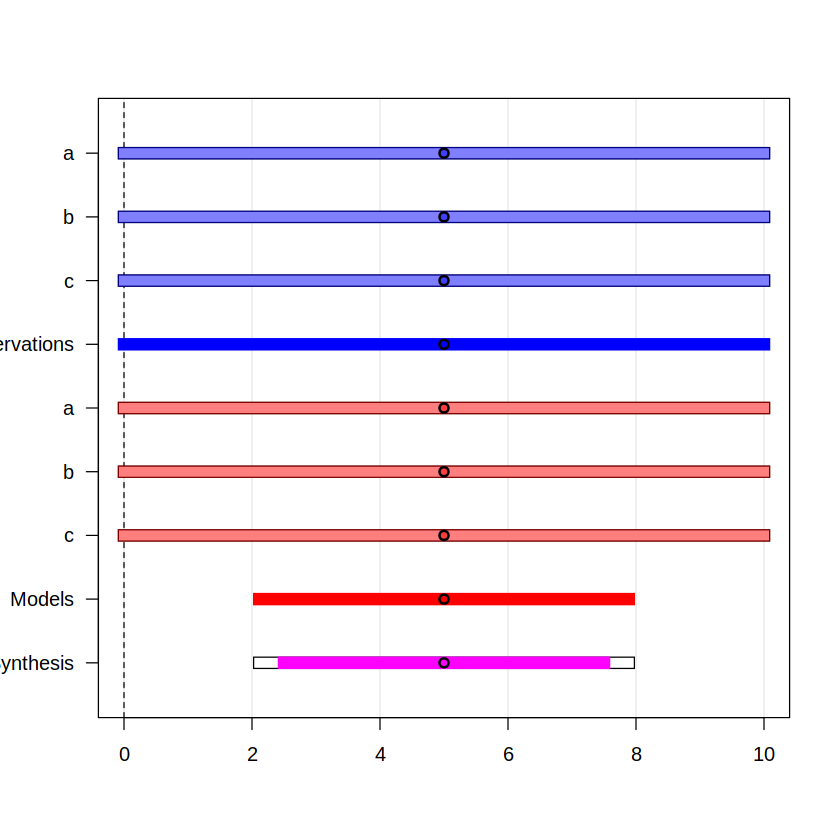

In [56]:
# specify model parameters
n = 3
mu = rep(5,n)
sigma = (10 - mu) / qnorm(0.975)
sig_mod = 0

# turn variances into bounds and run through synthesis
sim_bounds <- data.frame(t(sapply(1:length(mu), function(j) setNames(c(mu[j], qnorm(c(0.025, 0.975), mu[j], sigma[j]+sig_mod)), c("est", "lower", "upper")))),
                         row.names = letters[1:length(mu)])

zz = synthesis(obs_in = sim_bounds, models_in = sim_bounds)
plot_synthesis(zz, add_space = F)

In [57]:
# width of obs interval
int_obs = diff(unlist(zz$df[zz$df$group == "obs_synth",c("est", "upper")])) 
int_mdl = diff(unlist(zz$df[zz$df$group == "model_synth",c("est", "upper")]))

# ratio of model interval to obs interval is sqrt(n)
(int_obs / int_mdl)^2

upper 
    3

### Obs synthesis

In [58]:
mu_obs = 1/n * sum(mu)

# check width of obs interval
sig_obs = 1/n * sum(sigma)
mu_obs + qnorm(0.975) * sig_obs

[1] 10

### Model synthesis

The individual model weights are
$\begin{align}
&w_j = \frac{k}{\sigma_j^2}
\end{align}$ where $k = \left(2 \times 1.96\right)^{-2}$.


In [59]:
# calculate weights from sigma - should match print when running synthesis
w = round(1/(((2*1.96)^2) * sigma^2), 2)
w

[1] 0.01 0.01 0.01

The upper bound of the dark red bar is 
$\begin{align}\mu_{mod} + \frac{1.96}{\sqrt{\sum_j \sigma_j^{-2}}}
\end{align}$

In [60]:
# model mean
mu_mod = sum(w*mu)/sum(w)

# model SD
sqrt(sum((w*sigma)^2)) / sum(w)

# and again, but this time using sum of precisions directly
sig_mod = 1/sqrt(sum(1/sigma^2))
sig_mod

[1] 1.472859

[1] 1.472859

In [61]:
# check the upper limit of the interval
mu_mod + qnorm(0.975) * sig_mod
zz$df[zz$df$group == "model_synth", "upper"]

[1] 7.886751

[1] 7.886751

### Overall synthesis

In [62]:
# compute weights
k = (2*1.96)^2
w_obs = k / sig_obs^2
w_mod = k / sig_mod^2

In [63]:
# compute synthesised mean
mu_synth = mean(mu_mod, mu_obs)

# synthesised variance
sig_synth = 1/sqrt(sig_obs^{-2} + sig_mod^{-2})

In [64]:
# check bounds
mu_synth + qnorm(0.975) * sig_synth
zz$df[zz$df$group == "synth","upper"]

[1] 7.5

[1] 7.5

## All obs agree, all models agree but are biased

Still heavily prioritising the models even though the same number of obs are also in full agreement

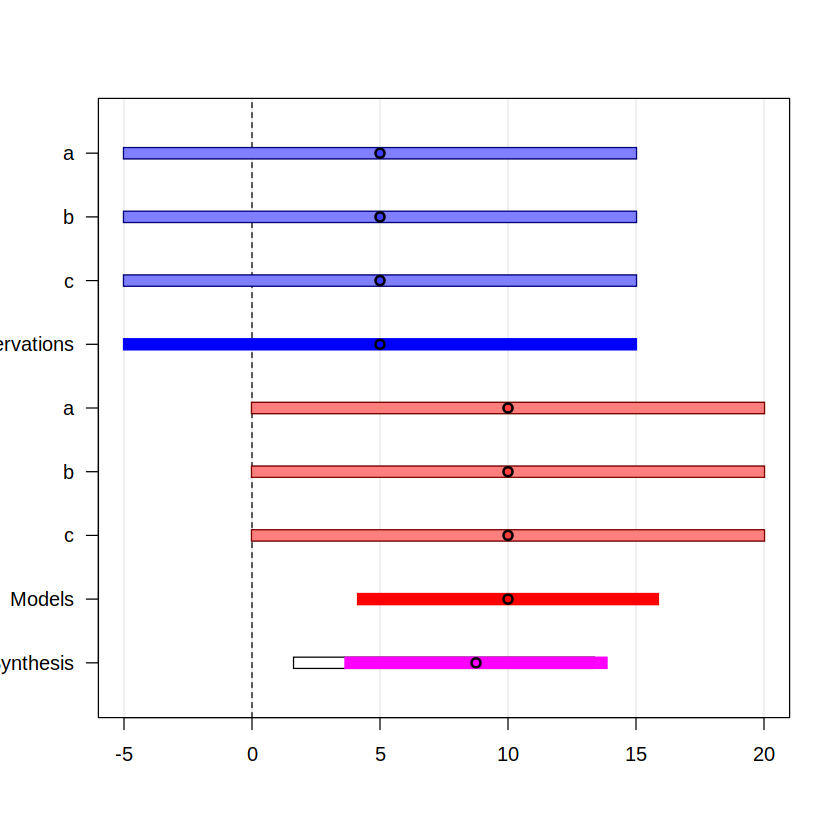

In [55]:
# specify model parameters
n = 3
mu_obs = rep(5, n)
mu_mod = rep(10,n)

sigma_obs = rep(5, n)
sigma_mod = rep(5, n)

# turn variances into bounds and run through synthesis
obs_bounds <- data.frame(t(sapply(1:length(mu_obs), function(j) setNames(c(mu_obs[j], qnorm(c(0.025, 0.975), mu_obs[j], sigma_obs[j])), c("est", "lower", "upper")))),
                         row.names = letters[1:length(mu_obs)])
                           
mdl_bounds <- data.frame(t(sapply(1:length(mu_mod), function(j) setNames(c(mu_mod[j], qnorm(c(0.025, 0.975), mu_mod[j], sigma_mod[j])), c("est", "lower", "upper")))),
                         row.names = letters[1:length(mu_mod)])

zz = synthesis(obs_in = obs_bounds, models_in = mdl_bounds)
plot_synthesis(zz, add_space = F)

---
# Modified synthesis functions
Modifications to match version in paper:

In [105]:
getsynmean_v1 <- function(data, sig_mod = 0) {

  # calculate weight for each model based on inverse variance
  w = 1/(((data$upper - data$lower))^2 + (2*sig_mod)^2)     # w = 1/(((data$upper - data$lower)/(2*1.96))^2 + sig_mod^2)
  w1 = sum(w)
    
  print(w)

  # weighted sum of squares & bounds
  s1 <- sum(w*data$est) / w1
  ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
  ss2 <- sqrt(ss2) / w1

  # if non-zero model representation error, extend 95% intervals accordingly
  if (sig_mod > 0) {
      ss2 <- sqrt(ss2^2 + (2*sig_mod)^2)     # ss2 <- sqrt(ss2^2 + (1.96*sig_mod)^2)
  }

  return(s1 + (ss2 * c(0,-1,1)))
}

In [106]:
getsynchi2_v1 <- function(data, sig_mod = 0) {

  # function to be minimized by finding sig_mod such that chi^2/mdof ~= 1

  # get best estimate of weighted mean
  s1 <- getsynmean_v1(data, sig_mod)["est"]

  # compute chi2 by converting model intervals to standard deviations & adding sig_mod adjustment
  chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
    if(x["est"] > s1) {
      (x["est"] - s1)^2 / (((x["est"] - x["lower"]))^2 + sig_mod^2)     # (x["est"] - s1)^2 / (((x["est"] - x["lower"])/1.96)^2 + sig_mod^2)
    } else {
      (x["est"] - s1)^2 / (((x["est"] - x["upper"]))^2 + sig_mod^2)     # (x["est"] - s1)^2 / (((x["est"] - x["upper"])/1.96)^2 + sig_mod^2)
    }
  }))
  return(chi2*4)
}

In [107]:
synthesis_v1 <- function(obs_in = NA, models_in, synth_type = "abs") {

  if(is.na(unlist(obs_in))[1]) {
    no_obs <- T
    # create a dummy dataframe to avoid having to rewrite everything twice
    obs_in <- data.frame("est" = 0, "lower" = 0, "upper" = 0)
    rownames(obs_in) <- "dummy"
  } else {
    no_obs <- F
  }

  # relabel the data for easier reference later
  colnames(obs_in) <- colnames(models_in) <- c("est", "lower", "upper")

  if(!("model" %in% colnames(obs_in))) obs_in$model <- rownames(obs_in)
  if(!("model" %in% colnames(models_in))) models_in$model <- rownames(models_in)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  if(!synth_type %in% c("abs", "rel", "PR")) {
    cat(paste0("Synthesis type '",synth_type,"' not implemented - must be abs, rel or PR"), "\n")
  }

  if(synth_type == "PR") {
    obs_in[,c("est", "lower", "upper")] <- log(obs_in[,c("est", "lower", "upper")])
    models_in[,c("est", "lower", "upper")] <- log(models_in[,c("est", "lower", "upper")])
  } else if(synth_type == "rel") {
    obs_in[,c("est", "lower", "upper")] <- log(1+obs_in[,c("est", "lower", "upper")]/100)
    models_in[,c("est", "lower", "upper")] <- log(1+models_in[,c("est", "lower", "upper")]/100)
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get mean of intervals to estimate natural variability component

  # compute representation error from scatter of mean ($\sigma_{rep}$ in the paper)
  nobs = nrow(obs_in)
  obs <- apply(obs_in[,c("est", "lower", "upper"),drop = F], 2, mean)
  if(nobs == 1) {
    sig_obs = 0
  } else {
    s2 = sum((obs_in$est - obs[1])^2)
    sig_obs = 2 * sqrt(s2/(nobs-1))     # sig_obs = sqrt(s2/(nobs-1))
  }

  # add representation error to individual observations
  obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + (sig_obs)**2)     # obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + (1.96*sig_obs)**2)
  obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + (sig_obs)**2)     # obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + (1.96*sig_obs)**2)

  # apply representation error to obs synthesis
  # we're working with confidence intervals here, so we extend them by adding (1.96sig_obs)^2 in quadrature
  obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + (sig_obs)**2 )     # obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + (1.96*sig_obs)**2 )
  obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + (sig_obs)**2 )     # obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + (1.96*sig_obs)**2 )

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # get initial estimate of model mean & calculate chi^2
  chi2 <- getsynchi2_v1(models_in, sig_mod = 0)
  mdof <- nrow(models_in)-1

  if ( chi2/mdof > 1 ) {
    # find sig_mod such that chi^2/dof = 1
    sig_mod <- optim(0, function(x) {
        (getsynchi2_v1(models_in, sig_mod = x) - (nrow(models_in)-1))^2},
                     method = "Brent", lower = 0, upper = 5)$par
      } else {
        sig_mod <- 0
      }
    cat("sig_mod: ", sig_mod,"\n")

  # get weighted model mean
  models <- getsynmean_v1(models_in, sig_mod = sig_mod)

  # add representation error to individual models
  models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + (2*sig_mod)**2)     # models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + (2*sig_mod)**2)
  models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + (2*sig_mod)**2)     # models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + (2*sig_mod)**2)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # weighted mean of models & obs (coloured bar)
  w_obs <- unname((obs["upper"] - obs["lower"])^{-2})
  w_mod <- unname((models["upper"] - models["lower"])^{-2})

  wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
  synth <- setNames(c(wmean,
                      wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                      wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)),
                    c("est", "lower", "upper"))


  # unweighted mean of obs and models
  umean <- (obs["est"] +  models["est"]) / 2
  synth["l_wb"] <- umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2
  synth["u_wb"] <- umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # add group labels for easier plotting
  obs_in <- cbind(obs_in, "group" = "obs")
  obs <- data.frame(t(c("model" = "Observations", "group" = "obs_synth", obs)))
  models_in <- cbind(models_in, "group" = "models")
  models <- data.frame(t(c("model" = "Models", "group" = "model_synth", models)))
  synth <- data.frame(t(c("model" = "Synthesis", "group" = "synth", synth)))

  # combine all the data together in one dataframe
  res <- rbind.fill(obs_in, obs, models_in, models, synth)[,c("group", "model", "est", "lower", "upper", "l_wb", "u_wb")]
  for(cnm in c("est", "lower", "upper", "l_wb", "u_wb")) { res[,cnm] <- as.numeric(res[,cnm]) }

  # if only dummy obs, remove
  if(no_obs) {
    # drop all rows that don't relate to models
    res <- res[grepl("model", res$group),]
    sig_obs <- NA
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # reverse any transformations applied
  if(synth_type == "PR") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])
    sig_obs <- exp(sig_obs)
    sig_mod <- exp(sig_mod)
    umean <- exp(umean)
  } else if(synth_type == "rel") {
    res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- 100*(exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])-1)
    sig_obs <- 100*(exp(sig_obs)-1)
    sig_mod <- 100*(exp(sig_mod)-1)
    umean <- 100*(exp(umean)-1)
  }

  return(list(synth_type = synth_type, sig_obs = sig_obs, "chi2/dof" = chi2 / mdof, df = res, uw_mean = umean))
}

---
# Real examples

## Sahel heatwave
- model uncertainty on the obs
- no model uncertainty even though spread of model means is wider than the red bar
- synthesis puts essentially all the weight on the models

In [128]:
obs = read.csv("data/sahel_tx5x_obs.csv", row.names = 1)
models = read.csv("data/sahel_tx5x_models-past.csv", row.names = 1)

rownames(models) <- sapply(strsplit(rownames(models), "_"), "[", 1)

In [129]:
cat("Spread of model means:",round(diff(range(models$est)),2),"\n")
cat("Width of 95% interval from SD:", round(2*1.96*sd(models$est), 2),"\n")
cat("Width of red bar:", round(diff(unlist(synth_org$df[synth_org$df$group == "model_synth", c("lower", "upper")])),2))

Spread of model means: 0.45 
Width of 95% interval from SD: 0.62 
Width of red bar: 0.19

In [131]:
stype <- "abs"
synth_org = synthesis(obs, models, synth_type = stype)      # original code from Climate Explorer
synth_v1 = synthesis_v1(obs, models, synth_type = stype)    # modified to use variances instead of mixing intervals & variances

 [1] 1.1970371 3.0351224 2.6439289 3.7998396 4.6648536 2.5847541 2.6353517
 [8] 1.7132206 1.8410476 0.8573388 1.3840830 0.5713212 0.8401377
sig_mod:  0 
 [1] 1.1970371 3.0351224 2.6439289 3.7998396 4.6648536 2.5847541 2.6353517
 [8] 1.7132206 1.8410476 0.8573388 1.3840830 0.5713212 0.8401377


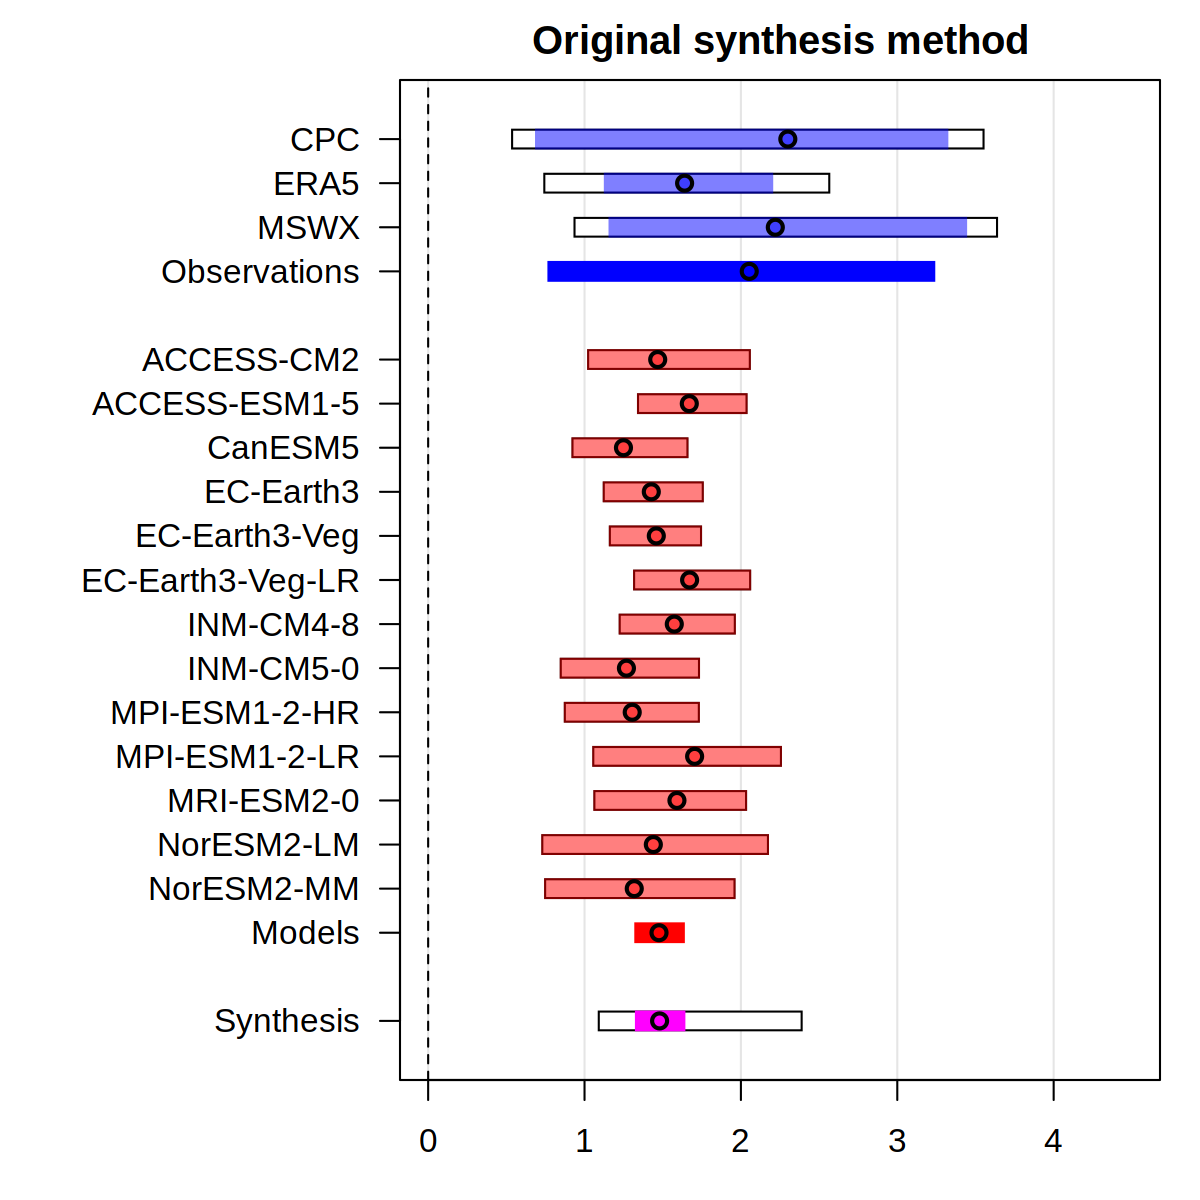

In [110]:
prep_window(h = 6, w = 6, mar = c(3,10,2,1))
plot_synthesis(synth_org, xlim = c(0,4.5), main = "Original synthesis method")